<a href="https://colab.research.google.com/github/lfernandezs/WordEmbeddingsTango/blob/main/analisisTango.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías

In [ ]:
!pip install tqdm
!pip install stanza
!pip install sentileak
!pip install sentiment_analysis_spanish

     |████████████████████████████████| 337kB 4.8MB/s 
     |████████████████████████████████| 20.1MB 3.0MB/s 
     |████████████████████████████████| 102kB 9.5MB/s 
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: snowballstemmer 2.1.0
    Uninstalling snowballstemmer-2.1.0:
      Successfully uninstalled snowballstemmer-2.1.0


     |████████████████████████████████| 30.0MB 106kB/s 


In [ ]:
import pandas             as pd
import numpy              as np
import matplotlib.pyplot  as plt
import seaborn            as sns

from sklearn.decomposition  import PCA
from sklearn.manifold       import TSNE
from google.colab           import drive
from tqdm.auto              import tqdm

# Limpieza de datos
import re
import string

# Librerías Natural Languaje ToolKit
import nltk
import stanza

nltk.download('stopwords')
stanza.download('es')

# Gensim
from gensim.models.phrases  import Phrases, Phraser
from gensim.corpora import Dictionary
from gensim.utils           import tokenize
from gensim.matutils        import corpus2csc
from gensim.models          import TfidfModel

# Sentiment Analysis
from sentileak import dataloader
from sentileak import SentiLeak

from sentiment_analysis_spanish import sentiment_analysis

# WordCloud
from wordcloud import WordCloud

# Word2Vec
import multiprocessing
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


2021-07-09 19:37:40 INFO: Downloading default packages for language: es (Spanish)...


2021-07-09 19:39:33 INFO: Finished downloading models and saved to /root/stanza_resources.


# Funciones Auxiliares

## Limpieza de datos

In [ ]:
def clean_text_1(text):
  # Minúscula
  text = text.lower()
  # Reemplaza signos de puntuación
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  # Remueve palabras que contienen números
  text = re.sub('\w*\d\w*', '', text)
  # Remueve símbolos raros
  simbolos = ["(", ")", "'", "¿", '...', '_', '-', '—', '¡', '"', '`']
  for s in simbolos:
    text = text.replace(s, ' ')
  # Remueve newlines
  text = re.sub('\n', ' ', text)
  # Remueve espacios duplicados
  text = re.sub(' +', ' ', text)
  return text

## Remover stopwords y lemmaatizar

In [ ]:
def inicializar_stanza():
  nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')
  sw = nltk.corpus.stopwords.words('spanish')
  return (nlp, sw)

def remove_sw(text, nlp, sw):
  words = text.split(' ')
  words_clean = []
  for w in words:
    if w:
      if w == 'él' or w == 'ella':
        words_clean.append(w)
      elif w not in sw:
        words_clean.append(nlp(w).sentences[0].words[0].lemma)
  return ' '.join(words_clean)

## Bigramas

In [ ]:
def bigrams(data):
  input = [row.split() for row in data['lyric']]
  phrases = Phrases(input, min_count=30, progress_per=1000) 
  bigram = Phraser(phrases)
  sentences = bigram[input]

  return sentences

# Funciones Principales

## Entrenar Word2Vec
**`df`** es un Dataframe que contiene una columna **`lyric`**. Se entrena el Word2Vec de esos lyrics.  
Devuelve el `w2v_model`.

In [ ]:
def entrenar_w2v(df):
  tqdm.pandas()
  data_clean = pd.DataFrame(df.lyric.progress_apply(lambda x: clean_text_1(x)))
  data_clean = pd.DataFrame(data_clean.lyric.progress_apply(lambda x: clean_text_2(x)))
  data_clean = pd.DataFrame(data_clean.lyric.progress_apply(lambda x: remove_sw(x, nlp, sw)))
  sentences = bigrams(data_clean)
  if not sentences: return None
  cores = multiprocessing.cpu_count()

  w2v_model = Word2Vec(min_count=5,
                      window=4,
                      size=300,
                      sample=6e-5,
                      alpha=0.03,
                      min_alpha=0.0007,
                      negative=20,
                      workers=cores)
  w2v_model.build_vocab(sentences)
  w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
  w2v_model.init_sims(replace=True)
  return w2v_model

## Scatterplot de palabras más cercanas

In [ ]:
def tsnescatterplot(model, word, list_names, topn):

    sns.set_style("darkgrid")
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    close_words = model.wv.most_similar([word], topn=topn)
    
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    reduc = PCA(n_components=10).fit_transform(arrays)
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE de {}'.format(word.title()))

## Entrenar w2v feliz y triste
Dado un **`df`** con los lyrics de las canciones (columna **`lyric`**), devuelve dos `w2v_model`, uno entrenado con las canciones más alegres y otro con las más tristes.

In [ ]:
def w2v_por_sentimiento(df, median):
  sentimental = sentiment_analysis.SentimentAnalysisSpanish()
  df['Sentimiento'] = df['lyric'].apply(lambda x: np.mean([sentimental.sentiment(f) for f in x.split('.')]))
  if not median: median = df['Sentimiento'].median()
  cancion_feliz = df.loc[df['Sentimiento'] > median]
  cancion_triste = df.loc[df['Sentimiento'] <= median]
  w2v_model_feliz = entrenar_w2v(cancion_feliz)
  w2v_model_triste = entrenar_w2v(cancion_triste)
  return w2v_model_feliz, w2v_model_triste

## Entrenar w2v por época
Dado un **`df`** con una columna **`lyric`** y una columna **`year`**, devuelve una lista de modelos w2v, entrenados con lyrics de cada k años.  
Esto a veces me tira error cuando hay poca información en cada intervalo.

In [ ]:
def w2v_por_epoca(df, k):
  desde = df['year'].min()
  hasta = df['year'].max()
  modelos = []
  for i in range(desde, hasta, k):
    print(f'Año: {i}')
    df_aux = df.loc[(df['year'] >= desde) & (df['year'] < desde + k)]
    w2v_model = entrenar_w2v(df_aux)
    if not w2v_model: continue
    modelos.append(w2v_model)
  return modelos

## Entrenar w2v por artista
Dado un **`df`** con una columna **`lyric`** y una columna **`artist`**, devuelve una lista de modelos w2v, entrenados con lyrics de ese artista.

In [ ]:
def w2v_por_artista(df, artista):
  df_artista = df.loc[df['artista'] == artista]
  w2v_model = entrenar_w2v(df_artista)
  return w2v_model

## WordClouds

In [ ]:
def wordcloud(frequencies, dict_atr):
  wc = WordCloud(**dict_atr).generate_from_frequencies(frequencies)
  return wc

--------------------------------------------

# Ejecución

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filename = '/content/drive/My Drive/Colab Notebooks/tangos.csv'
df = pd.read_csv(filename).dropna(subset=['lyric'])
df = df.drop(df.columns[[0, 5, 6]], axis=1) # Lo último es para borrar unas columnas extras que me aparecían

w2v con todas las canciones

In [ ]:
w2v_model = entrenar_w2v(df)

In [ ]:
w2v_model.save('tangos.w2v')

w2v dividido entre las felices y las tristes

In [ ]:
w2v_feliz, w2v_triste = w2v_por_sentimiento(df, 0.4)

In [ ]:
w2v_feliz.save('tangos_feliz.w2v')
w2v_triste.save('tangos_triste.w2v')

# Análisis del tango

El tango es un género musical que comenzó a gestarse desde 1860 en Argentina y Uruguay. Nació entre las clases bajas de Buenos Aires y Montevideo. En sus raíces se destacan la cultura gauchesca, hispana, africana, italiana y muchas más, porq la gran diversidad étnica de la ola migratoria de esos años.

Nos proponemos responder las siguientes preguntas (o intentarlo):
* ¿Qué palabras se utilizan para hablar de un hombre?
* ¿Qué palabras  se utilizan para hablar de una mujer?
* ¿Cambian con la emotividad de la canción?
* ¿Evolucionaron con el pasar del tiempo?
* ¿Hay diferencias marcadas según el artista que compuso las canciones?

In [ ]:
w2v_model = Word2Vec.load('tangos.w2v')

## Diferencias de géneros

¿Qué palabras se acercan más a "mujer" ó a "ella"?

In [ ]:
w2v_model.wv.most_similar(positive='mujer')

[('leal', 0.9549416899681091),
 ('ofrecer', 0.9506291151046753),
 ('compañera', 0.9502280950546265),
 ('sincero', 0.9476680755615234),
 ('gozar', 0.9474782943725586),
 ('distar', 0.9473724365234375),
 ('vicio', 0.9447598457336426),
 ('pues', 0.9441124200820923),
 ('santo', 0.9383970499038696),
 ('grande', 0.9377262592315674),
 ('joven', 0.9369271993637085)]

In [ ]:
w2v_model.wv.most_similar(positive='ella')

[('abandonar', 0.9799908399581909),
 ('apenar', 0.9772439002990723),
 ('verdadero', 0.9770852327346802),
 ('rogar', 0.9748802781105042),
 ('ingrato', 0.97437983751297),
 ('sincero', 0.9738016128540039),
 ('aliviar', 0.9730413556098938),
 ('solamente', 0.9718337059020996),
 ('bes', 0.971264123916626),
 ('único', 0.9707845449447632),
 ('perjurar', 0.970562756061554)]

¿Qué palabras se acercan más a "hombre" ó a "él"?

In [ ]:
w2v_model.wv.most_similar(positive='hombre')

[('malo', 0.9859627485275269),
 ('vergüenza', 0.9817746877670288),
 ('juez', 0.9728562831878662),
 ('consejo', 0.9727229475975037),
 ('quisistar', 0.9725596904754639),
 ('viejito', 0.9689061045646667),
 ('traicionar', 0.9684799909591675),
 ('aconsejar', 0.9671355485916138),
 ('ruin', 0.9662542343139648),
 ('derecho', 0.9655261635780334),
 ('demás', 0.9648571610450745)]

In [ ]:
w2v_model.wv.most_similar(positive='él', topn=11)

[('lección', 0.9828444719314575),
 ('resolver', 0.9826415777206421),
 ('ofender', 0.9821208715438843),
 ('decilar', 0.9788050055503845),
 ('pedido', 0.9776006937026978),
 ('enemigo', 0.9771934747695923),
 ('engañás', 0.9760633707046509),
 ('valorar', 0.9760199785232544),
 ('acostumbrar', 0.9759191870689392),
 ('entregado', 0.9757932424545288),
 ('apreciar', 0.9753429889678955)]

## Diferencias de género en canciones positivas y negativas

### Canciones positivas

In [ ]:
w2v_feliz = Word2Vec.load('tangos_feliz_2.w2v')
w2v_triste = Word2Vec.load('tangos_triste_2.w2v')

¿Qué palabras se acercan más a "mujer" ó a "ella"?

In [ ]:
w2v_feliz.wv.most_similar(positive='mujer')

[('alma', 0.9999537467956543),
 ('mirar', 0.9999525547027588),
 ('volver', 0.9999523162841797),
 ('blanco', 0.9999517202377319),
 ('cálido', 0.9999517202377319),
 ('amar', 0.9999517202377319),
 ('lugar', 0.9999514818191528),
 ('pena', 0.9999513030052185),
 ('canción', 0.9999510049819946),
 ('amargura', 0.9999508857727051),
 ('gol', 0.9999507665634155)]

In [ ]:
w2v_feliz.wv.most_similar(positive='ella')

[('muchacho', 0.9999528527259827),
 ('pena', 0.9999520778656006),
 ('barro', 0.9999498128890991),
 ('sueño', 0.9999498128890991),
 ('oscuro', 0.9999496936798096),
 ('paisaje', 0.99994957447052),
 ('llamar', 0.9999493956565857),
 ('moza', 0.9999490976333618),
 ('ciudad', 0.9999489188194275),
 ('pasión', 0.9999484419822693),
 ('hacer', 0.999948263168335)]

¿Qué palabras se acercan más a "hombre" ó a "él"?

In [ ]:
w2v_feliz.wv.most_similar(positive='hombre')

[('ciudad', 0.9999589920043945),
 ('venir', 0.9999589920043945),
 ('pena', 0.999957799911499),
 ('muchacho', 0.9999568462371826),
 ('mirar', 0.999956488609314),
 ('sueño', 0.9999545812606812),
 ('tren', 0.999954342842102),
 ('rodar', 0.9999540448188782),
 ('tango', 0.9999536275863647),
 ('decir', 0.9999533295631409)]

In [ ]:
w2v_feliz.wv.most_similar(positive='él')

[('gardel', 0.9999415874481201),
 ('cara', 0.9999415874481201),
 ('ausencia', 0.9999414682388306),
 ('pena', 0.9999409317970276),
 ('ciudad', 0.9999406933784485),
 ('"', 0.9999403953552246),
 ('mientras', 0.9999403953552246),
 ('paisaje', 0.9999403357505798),
 ('año', 0.9999402165412903),
 ('volar', 0.9999397993087769),
 ('viejo', 0.9999394416809082)]

### Canciones negativas

¿Qué palabras se acercan más a "mujer" ó a "ella"?

In [ ]:
w2v_triste.wv.most_similar(positive='mujer')

[('sincero', 0.9714762568473816),
 ('gozar', 0.9714597463607788),
 ('pues', 0.9692984819412231),
 ('vicio', 0.9656469821929932),
 ('supir', 0.9654565453529358),
 ('leal', 0.9643659591674805),
 ('ella', 0.963696300983429),
 ('grande', 0.9623314142227173),
 ('distar', 0.9611366987228394),
 ('pobrecito', 0.9604313969612122),
 ('lealtad', 0.9590345025062561),
 ('despreciar', 0.9583998918533325),
 ('fortuna', 0.9578553438186646),
 ('acordar', 0.9542546272277832)]

In [ ]:
w2v_triste.wv.most_similar(positive='ella')

[('sincero', 0.9875739812850952),
 ('apenar', 0.9802507162094116),
 ('abandonar', 0.9801893830299377),
 ('solamente', 0.9797952771186829),
 ('supir', 0.9777782559394836),
 ('prometer', 0.9767986536026001),
 ('entregar', 0.9765030145645142),
 ('despreciar', 0.9760233163833618),
 ('perjurar', 0.9758548140525818),
 ('verdadero', 0.9755028486251831),
 ('rogar', 0.9752110242843628)]

In [ ]:
w2v_triste.wv.most_similar(positive='hombre')

[('malo', 0.9875000715255737),
 ('quisistar', 0.9856019020080566),
 ('vergüenza', 0.9813128113746643),
 ('demostrar', 0.9795352220535278),
 ('pagar', 0.9771183729171753),
 ('traicionar', 0.9754838943481445),
 ('haber', 0.974713146686554),
 ('deber', 0.9717484712600708),
 ('padre', 0.970291256904602),
 ('creer', 0.9683111310005188)]

In [ ]:
w2v_triste.wv.most_similar(positive='él')

[('esposa', 0.9891752004623413),
 ('deuda', 0.9871690273284912),
 ('engañás', 0.9870821833610535),
 ('convenir', 0.9870611429214478),
 ('niño', 0.9858888387680054),
 ('resolver', 0.9856513142585754),
 ('trance', 0.984430193901062),
 ('andáte', 0.9834789037704468),
 ('dejalar', 0.9832870960235596),
 ('francamente', 0.9830737113952637)]

## Atorrante

¿Qué significa que un hombre sea 'atorrante'?

In [ ]:
w2v_model.wv.most_similar(positive=['atorrante', 'hombre'])

[('prepotencia', 0.9889070987701416),
 ('dejatir', 0.9848529100418091),
 ('maña', 0.9842661619186401),
 ('feo', 0.9839216470718384),
 ('conformar', 0.9834628701210022),
 ('esquinazo', 0.982857882976532),
 ('cuestión', 0.9817150831222534),
 ('engrubir', 0.981433629989624),
 ('mantener', 0.9809415340423584),
 ('yuta', 0.9799107313156128),
 ('decidido', 0.9790225625038147),
 ('marido', 0.978821873664856),
 ('mishiadura', 0.9785956144332886),
 ('olvidés', 0.9785815477371216),
 ('dao', 0.9783047437667847),
 ('criticar', 0.9778379201889038),
 ('según', 0.9761931896209717),
 ('ventaja', 0.975517988204956),
 ('protestar', 0.9748931527137756),
 ('valés', 0.9747637510299683)]

¿Qué es a 'mujer' lo que 'atorrante' es a hombre?

In [ ]:
w2v_model.wv.most_similar(positive=['atorrante', 'mujer'], negative=['hombre'])

[('vestir', 0.9827488660812378),
 ('coqueta', 0.9781981706619263),
 ('derrochar', 0.9747908115386963),
 ('gracioso', 0.9716352224349976),
 ('cautivar', 0.9684998393058777),
 ('sala', 0.9683561325073242),
 ('nervioso', 0.9680449962615967),
 ('pizpireta', 0.9667020440101624),
 ('zapatito', 0.9666156768798828),
 ('mascotita', 0.9642159938812256)]

## Orillero

In [ ]:
w2v_model.wv.most_similar(positive=['orillero', 'hombre'], negative=['mujer'])

[('botón', 0.9392216205596924),
 ('copar', 0.9267889261245728),
 ('cuatro', 0.9234347343444824),
 ('punta', 0.9196673631668091),
 ('cuarenta', 0.9196090698242188),
 ('once', 0.9132838249206543),
 ('tallar', 0.9110404253005981),
 ('gordo', 0.9101743102073669),
 ('cacho', 0.9098158478736877),
 ('ligero', 0.9078772068023682)]

In [ ]:
w2v_model.wv.most_similar(positive=['orillero', 'mujer'], negative=['hombre'])

[('poeta', 0.9610801935195923),
 ('pareja', 0.9592643976211548),
 ('suburbio', 0.9564211964607239),
 ('maleva', 0.9555255770683289),
 ('cedrón', 0.9536415338516235),
 ('gentil', 0.9528270959854126),
 ('musa', 0.9524315595626831),
 ('arrabalero', 0.951435923576355),
 ('milongón', 0.9508661031723022),
 ('enredar', 0.9496427178382874)]

## Pizpireta

In [ ]:
w2v_model.wv.most_similar(positive=['pizpireta', 'mujer'])

[('milonguitar', 0.9534140825271606),
 ('preferido', 0.9522072672843933),
 ('diosa', 0.9499063491821289),
 ('cautivar', 0.9337620139122009),
 ('mimado', 0.9327958822250366),
 ('franco', 0.932288646697998),
 ('delicia', 0.9280923008918762),
 ('mocedad', 0.9248697757720947),
 ('gracia', 0.9238624572753906),
 ('vulgar', 0.9227582216262817)]

In [ ]:
w2v_model.wv.most_similar(positive=['pizpireta', 'hombre'], negative=['mujer'], topn=20)

[('tapa', 0.9779503345489502),
 ('leche', 0.9749021530151367),
 ('pellejo', 0.9743479490280151),
 ('patear', 0.9717594385147095),
 ('rajir', 0.9712762236595154),
 ('manga', 0.9704407453536987),
 ('soñás', 0.9698190689086914),
 ('marcador', 0.9693377017974854),
 ('apuntar', 0.969240128993988),
 ('bancar', 0.9689458012580872),
 ('codo', 0.9688173532485962),
 ('bicicleta', 0.9684320688247681),
 ('pelea', 0.9678846597671509),
 ('palmera', 0.9668692350387573),
 ('horno', 0.9668567180633545),
 ('crisis', 0.96659255027771),
 ('redoblona', 0.9661311507225037),
 ('potrillo', 0.965938150882721),
 ('varios', 0.9658105969429016),
 ('tomalar', 0.9657784700393677)]

## Odiar y amar con pasión

In [ ]:
w2v_model.wv.most_similar(positive=['pasión'])

[('encanto', 0.9701238870620728),
 ('sublime', 0.9616708159446716),
 ('ventura', 0.9571325778961182),
 ('ardiente', 0.9546709060668945),
 ('amor', 0.9524416327476501),
 ('caricia', 0.9501039981842041),
 ('ilusión', 0.9419574737548828),
 ('fervor', 0.941545307636261),
 ('amado', 0.9403142929077148),
 ('profundo', 0.9386763572692871)]

In [ ]:
w2v_model.wv.most_similar(positive=['amor'])

[('sublime', 0.9768869876861572),
 ('amar', 0.9764151573181152),
 ('caricia', 0.975938618183136),
 ('amoroso', 0.9751049280166626),
 ('dicho', 0.9707192182540894),
 ('ventura', 0.970492959022522),
 ('felicidad', 0.9688867330551147),
 ('amado', 0.9668660163879395),
 ('lograr', 0.9661361575126648),
 ('ilusión', 0.9601088762283325)]

In [ ]:
w2v_model.wv.most_similar(positive=['odio'])

[('duda', 0.9728277921676636),
 ('garra', 0.9718261957168579),
 ('cadena', 0.9685289859771729),
 ('maldito', 0.9680067896842957),
 ('matar', 0.9656062126159668),
 ('soportar', 0.9648911952972412),
 ('torpe', 0.9623980522155762),
 ('falsedad', 0.9603505730628967),
 ('burlar', 0.9601176381111145),
 ('odiar', 0.9586312770843506)]

In [ ]:
w2v_model.wv.most_similar(positive=['pasión', 'odio'])

[('agravio', 0.9643965363502502),
 ('delirio', 0.9622361660003662),
 ('ciego', 0.9617323875427246),
 ('mentido', 0.9595792293548584),
 ('confiar', 0.95918869972229),
 ('destrozar', 0.9590399265289307),
 ('celo', 0.9550061225891113),
 ('pecho', 0.9536603689193726),
 ('capricho', 0.9522993564605713),
 ('enojo', 0.9515905380249023)]

In [ ]:
w2v_model.wv.most_similar(positive=['pasión', 'amor'])

[('sublime', 0.9810129404067993),
 ('ventura', 0.9754806756973267),
 ('caricia', 0.974679708480835),
 ('encanto', 0.9726191759109497),
 ('amoroso', 0.9655022621154785),
 ('amado', 0.9651343822479248),
 ('ilusión', 0.9625464677810669),
 ('fervor', 0.957927942276001),
 ('amante', 0.9536493420600891),
 ('ideal', 0.9526654481887817)]

## Palabras más usadas por Edmundo Rivero en sus canciones 

In [ ]:
edmundo_rivero = ['Amablemente', 'Atenti pebeta', 'Cuando me entrés a fallar']
df_ER = df.loc[np.isin(df['name'], edmundo_rivero)]

# Limpio las palabras raras y stopwords
nlp, sw = inicializar_stanza()
df_ER.lyric = pd.DataFrame(df_ER.lyric.apply(lambda x: clean_text_1(x)))
df_ER.lyric = pd.DataFrame(df_ER.lyric.apply(lambda x: remove_sw(x, nlp, sw)))

### Analizando todas las canciones

(-0.5, 1199.5, 799.5, -0.5)

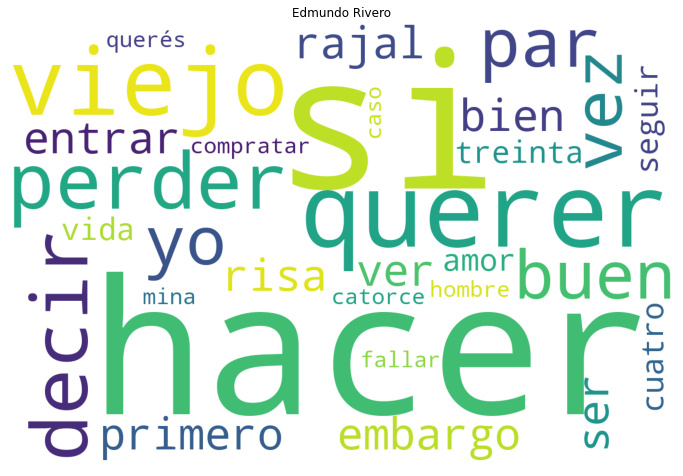

In [ ]:
frequencies = pd.Series(np.concatenate([x.split() for x in df_ER.lyric])).value_counts()

fig, axs = plt.subplots(figsize=(12, 10))
atrs = {'height':800,
        'width':1200,
        'background_color':'white',
        'max_words':30}

wc = wordcloud(frequencies, atrs)
axs.set_title("Edmundo Rivero")
axs.imshow(wc)
axs.axis('off')

### Analizando cada canción por separado

(-0.5, 1799.5, 1199.5, -0.5)

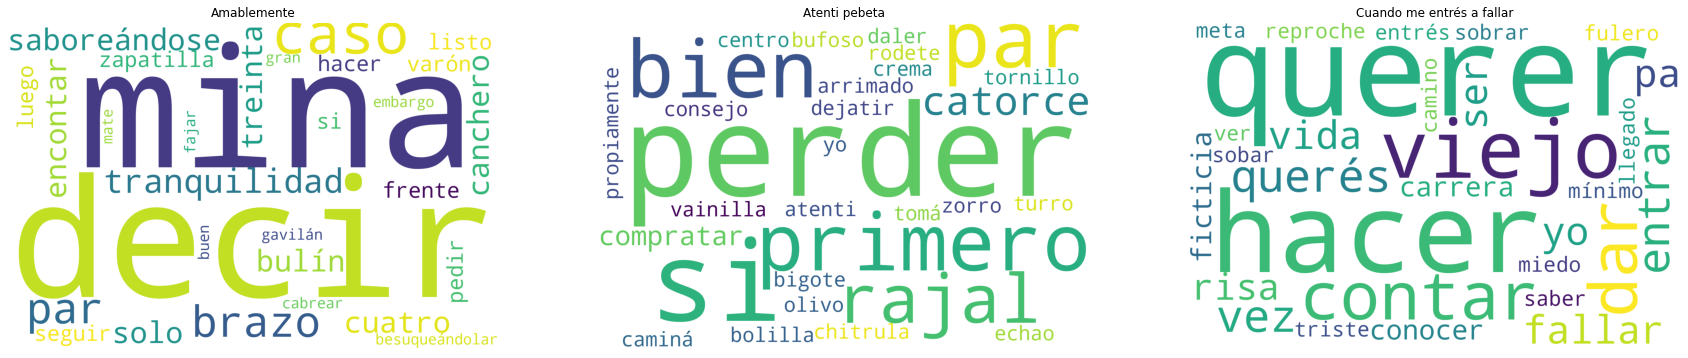

In [ ]:
frequencies = [pd.Series(df_ER.iloc[i,3].split()).value_counts().to_dict() for i in range(len(df_ER.index))]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 36))
atrs = {'height':1200,
        'width':1800,
        'background_color':'white',
        'max_words':30}

wc1 = wordcloud(frequencies[0], atrs)
axs[0].set_title(list(df_ER['name'])[0])
axs[0].imshow(wc1)
axs[0].axis('off')

wc2 = wordcloud(frequencies[1], atrs)
axs[1].set_title(list(df_ER['name'])[1])
axs[1].imshow(wc2)
axs[1].axis('off')

wc3 = wordcloud(frequencies[2], atrs)
axs[2].set_title(list(df_ER['name'])[2])
axs[2].imshow(wc3)
axs[2].axis('off')


## Palabras más usadas por Carlos Gardel en sus canciones 

In [ ]:
carlos_gardel = ['Por una cabeza', 'Mi Buenos Aires querido', 'Caminito']
df_CG = df.loc[np.isin(df['name'], carlos_gardel)]

# Limpio las palabras raras y stopwords
nlp, sw = inicializar_stanza()
df_CG.lyric = pd.DataFrame(df_CG.lyric.apply(lambda x: clean_text_1(x)))
df_CG.lyric = pd.DataFrame(df_CG.lyric.apply(lambda x: remove_sw(x, nlp, sw)))

### Analizando todas las canciones

(-0.5, 1199.5, 799.5, -0.5)

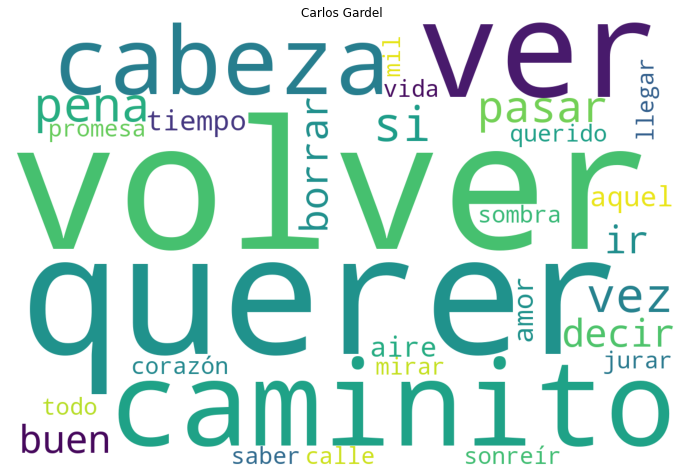

In [ ]:
frequencies = pd.Series(np.concatenate([x.split() for x in df_CG.lyric])).value_counts()

fig, axs = plt.subplots(figsize=(12, 10))
atrs = {'height':800,
        'width':1200,
        'background_color':'white',
        'max_words':30}

wc = wordcloud(frequencies, atrs)
axs.set_title("Carlos Gardel")
axs.imshow(wc)
axs.axis('off')

### Analizando cada canción por separado

(-0.5, 1799.5, 1199.5, -0.5)

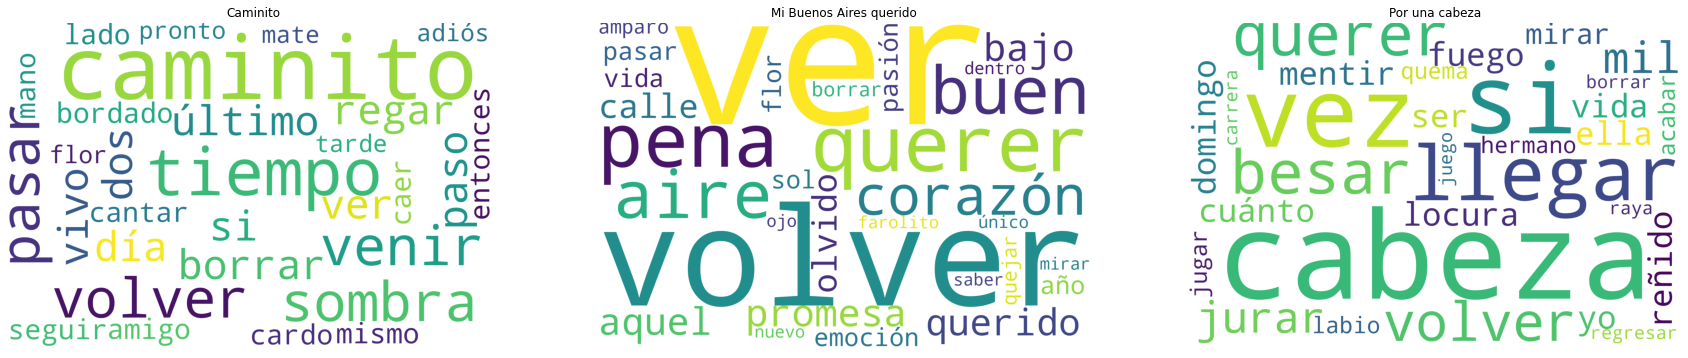

In [ ]:
frequencies = [pd.Series(df_CG.iloc[i,3].split()).value_counts().to_dict() for i in range(len(df_CG.index))]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 36))
atrs = {'height':1200,
        'width':1800,
        'background_color':'white',
        'max_words':30}

wc1 = wordcloud(frequencies[0], atrs)
axs[0].set_title(list(df_CG['name'])[0])
axs[0].imshow(wc1)
axs[0].axis('off')

wc2 = wordcloud(frequencies[1], atrs)
axs[1].set_title(list(df_CG['name'])[1])
axs[1].imshow(wc2)
axs[1].axis('off')

wc3 = wordcloud(frequencies[2], atrs)
axs[2].set_title(list(df_CG['name'])[2])
axs[2].imshow(wc3)
axs[2].axis('off')


## Palabras más usadas por Homero Manzi en sus canciones 

In [ ]:
df_HM = df.loc[df['artist'] == 'Homero Manzi']
homero_manzi = list(df_HM['name'])
# Limpio las palabras raras y stopwords
nlp, sw = inicializar_stanza()
df_HM.lyric = pd.DataFrame(df_HM.lyric.apply(lambda x: clean_text_1(x)))
df_HM.lyric = pd.DataFrame(df_HM.lyric.apply(lambda x: remove_sw(x, nlp, sw)))

2021-07-09 19:53:13 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |

2021-07-09 19:53:13 INFO: Use device: cpu
2021-07-09 19:53:13 INFO: Loading: tokenize
2021-07-09 19:53:13 INFO: Loading: mwt
2021-07-09 19:53:13 INFO: Loading: pos
2021-07-09 19:53:13 INFO: Loading: lemma
2021-07-09 19:53:13 INFO: Done loading processors!
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


### Analizando todas las canciones

(-0.5, 1199.5, 799.5, -0.5)

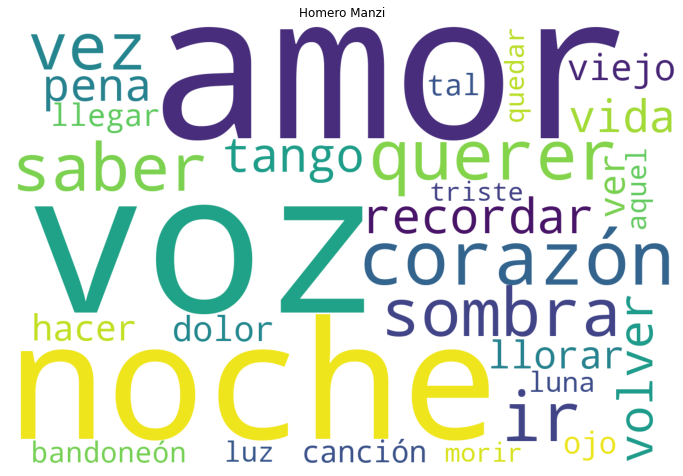

In [ ]:
frequencies = pd.Series(np.concatenate([x.split() for x in df_HM.lyric])).value_counts()

fig, axs = plt.subplots(figsize=(12, 10))
atrs = {'height':800,
        'width':1200,
        'background_color':'white',
        'max_words':30}

wc = wordcloud(frequencies, atrs)
axs.set_title("Homero Manzi")
axs.imshow(wc)
axs.axis('off')

### Analizando cada canción por separado

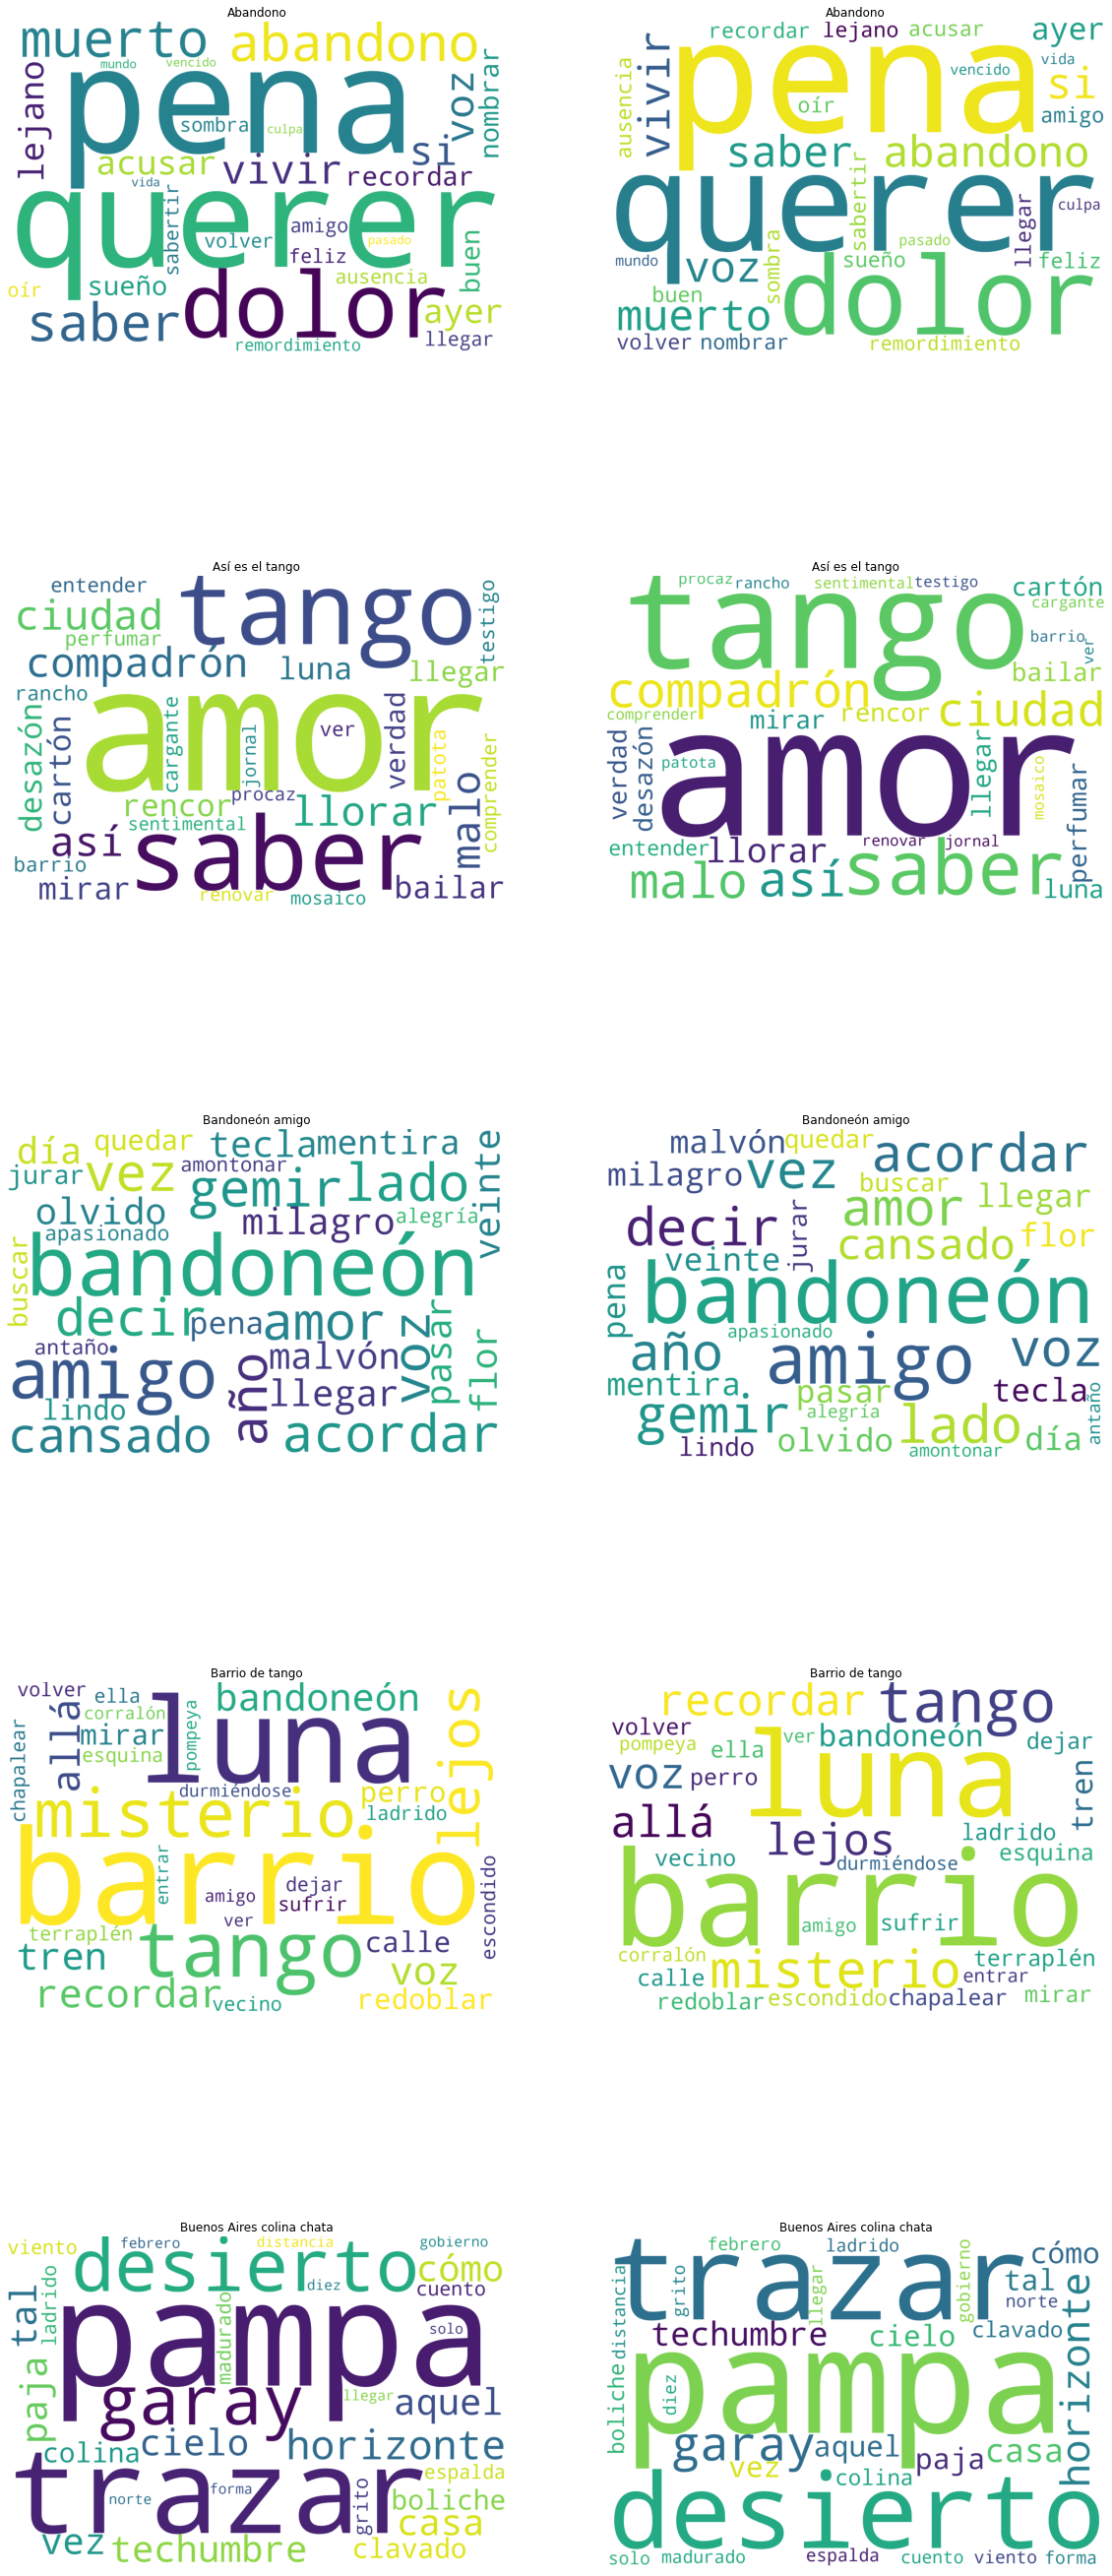

In [ ]:
frequencies = [pd.Series(df_HM.iloc[i,3].split()).value_counts().to_dict() for i in range(len(df_HM.index))]
n= 5
fig, axs = plt.subplots(nrows=n, ncols=2, figsize=(20, n*10))
atrs = {'height':1200,
        'width':1800,
        'background_color':'white',
        'max_words':30}
for i in range(n):
  wc = wordcloud(frequencies[i], atrs)
  axs[i,0].set_title(homero_manzi[i])
  axs[i,0].imshow(wc)
  axs[i,0].axis('off')

for i in range(n):
  wc = wordcloud(frequencies[i], atrs)
  axs[i,1].set_title(homero_manzi[i])
  axs[i,1].imshow(wc)
  axs[i,1].axis('off')
